In [3]:
import numpy as np
import pandas as pd
import os
import glob
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit.models import LorentzianModel, GaussianModel, SplineModel, VoigtModel

In [5]:
#loading 6 peaks
folder_path = 'spectroscopy_data/peaks_6'
csv_files = glob.glob(os.path.join(folder_path, '*.CSV')) 
dataframes6peaks = []
i=0
for file in csv_files:
    i +=1
    df = pd.read_csv(file)
    dataframes6peaks.append(df)
    print(f"{i} Loaded {file}:")  # Display first few rows of each file


1 Loaded spectroscopy_data/peaks_6\6_ (1).CSV:
2 Loaded spectroscopy_data/peaks_6\6_ (10).CSV:
3 Loaded spectroscopy_data/peaks_6\6_ (2).CSV:
4 Loaded spectroscopy_data/peaks_6\6_ (3).CSV:
5 Loaded spectroscopy_data/peaks_6\6_ (4).CSV:
6 Loaded spectroscopy_data/peaks_6\6_ (5).CSV:
7 Loaded spectroscopy_data/peaks_6\6_ (6).CSV:
8 Loaded spectroscopy_data/peaks_6\6_ (7).CSV:
9 Loaded spectroscopy_data/peaks_6\6_ (8).CSV:
10 Loaded spectroscopy_data/peaks_6\6_ (9).CSV:
11 Loaded spectroscopy_data/peaks_6\CS-BB-22.CSV:
12 Loaded spectroscopy_data/peaks_6\CS-BB-23.CSV:


In [6]:
y = dataframes6peaks[3]['CH1[V]'] * 100
x = dataframes6peaks[3]['[s]'] * 1000

In [7]:
def get_dataset(n):
    x = dataframes6peaks[n]['[s]'] * 1000
    y = dataframes6peaks[n]['CH1[V]'] * 100
    return x,y

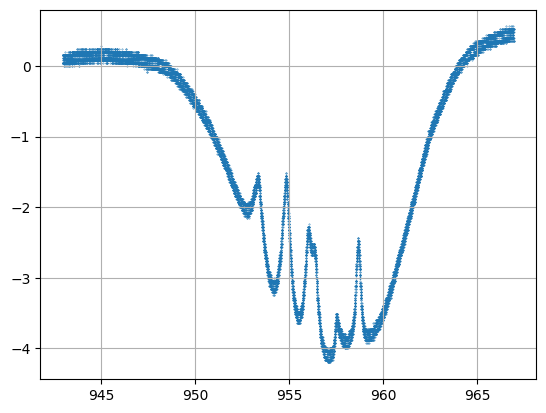

In [8]:
plt.scatter(x,y, s=0.1)
# plt.ylim(0,0.5)
# plt.xlim(960, 961)
plt.grid()

In [9]:
#function for moving average over 10 pts on the second axis

def move_ave(arr, window_size=10):
    window_size = 10

    numbers_series = pd.Series(arr)
    
    # Get the window of series
    # of observations of specified window size
    windows = numbers_series.rolling(window_size)
    
    # Create a series of moving
    # averages of each window
    moving_averages = windows.mean()
    
    # Convert pandas series back to list
    moving_averages_list = moving_averages.tolist()
    
    # Remove null entries from the list
    final_list = moving_averages_list[window_size - 1:]
    return final_list


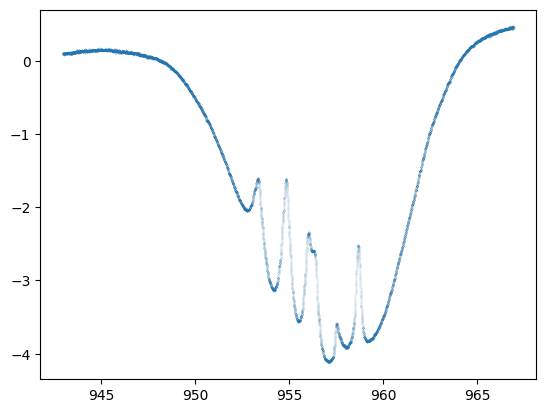

In [10]:
#getting&plotting moving averaged data
x_aveg = np.array(move_ave(x))
y_aveg = np.array(move_ave(y))
plt.scatter(x_aveg, y_aveg, s=0.001)

In [11]:
#defining knot making function
def get_knots(npoints = 10 , dataset=None, x=None, y=None, plotting = False):
    '''
        gets the knots positions at local minima in constants steps
        if plotting True : returns tuple xknots, yknots
    '''
    if dataset != None:
        x = dataset['[s]']
        y = dataset['CH1[V]']
    step = int(len(x)/npoints)
    knots = np.zeros(npoints, dtype=int)
    cutleft = 0
    cutright = step
    for n in range(npoints):
        localmin = y[cutleft:cutright].argmin()
        index_localmin = int(cutleft + localmin)
        knots[n] = index_localmin
        cutleft += step
        cutright += step
    if plotting:
        print('the knots are at second indices:', knots)
        print('the knots are at yvals:', y[knots])
        return (knots, y[knots])
    else:
        print('the knots are at seconds indices:', knots)
        return knots


In [12]:
#getting knots
xknots_indices, yknots = get_knots(x=x_aveg, y=y_aveg,  npoints = 20, plotting=True)

the knots are at second indices: [   70  1090  2850  3734  4994  5982  6989  7989  8986  9357 10442 11790
 11995 13489 13986 14985 15985 16993 17982 19008]
the knots are at yvals: [ 0.08   0.116  0.1    0.036 -0.156 -0.58  -1.228 -2.    -2.696 -3.144
 -3.576 -4.12  -4.048 -3.836 -3.664 -2.62  -1.328 -0.4    0.136  0.352]


(950.0, 957.0)

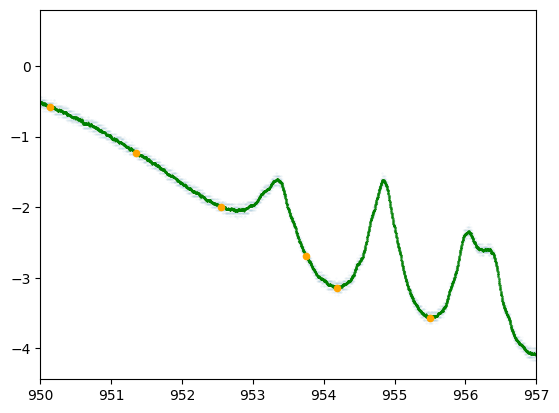

In [13]:
#plotting knots
plt.scatter(x,y, s=0.1, alpha=0.05)
plt.scatter(x_aveg,y_aveg, s=0.1, color= 'green')
plt.scatter(x_aveg[xknots_indices], yknots, s=20, color ='orange')
plt.xlim(950, 957)

In [14]:
#gauss model for bk
gauss = GaussianModel(prefix='gauss_')
params = gauss.guess(y_aveg, x_aveg)

In [15]:
model = gauss
out = model.fit(y_aveg, params, x=x_aveg)
print(out.fit_report(min_correl=0.3))
comps = out.eval_components()

[[Model]]
    Model(gaussian, prefix='gauss_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 110
    # data points      = 19991
    # variables        = 3
    chi-square         = 3451.97556
    reduced chi-square = 0.17270240
    Akaike info crit   = -35104.9025
    Bayesian info crit = -35081.1934
    R-squared          = 0.92338170
[[Variables]]
    gauss_amplitude: -33.5383997 +/- 0.06191124 (0.18%) (init = 165.0854)
    gauss_center:     957.293679 +/- 0.00739057 (0.00%) (init = 953.6516)
    gauss_sigma:      3.47012604 +/- 0.00740886 (0.21%) (init = 11.994)
    gauss_fwhm:       8.17152219 +/- 0.01744653 (0.21%) == '2.3548200*gauss_sigma'
    gauss_height:    -3.85573497 +/- 0.00711433 (0.18%) == '0.3989423*gauss_amplitude/max(1e-15, gauss_sigma)'
[[Correlations]] (unreported correlations are < 0.300)
    C(gauss_amplitude, gauss_sigma) = -0.5787


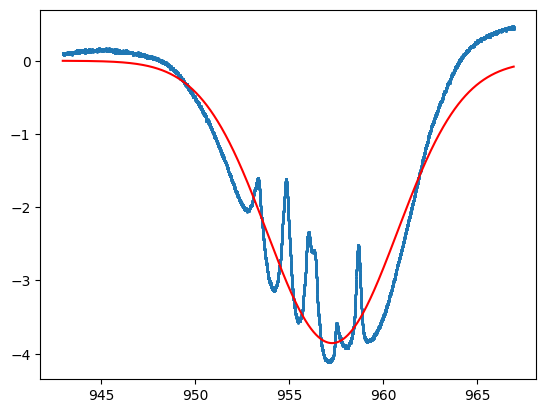

In [16]:
plt.scatter(x_aveg, y_aveg, s=1)
plt.plot(x_aveg, out.best_fit, label='best fit', color= 'red')

In [17]:
#spline model
bkg = SplineModel(prefix='bkg_', xknots=x_aveg[xknots_indices])
params = bkg.guess(y_aveg  , x_aveg)
params

name,value,initial value,min,max,vary
bkg_s0,0.08133333,None,-inf,inf,True
bkg_s1,0.11733333,None,-inf,inf,True
bkg_s2,0.10066667,None,-inf,inf,True
bkg_s3,0.03866667,None,-inf,inf,True
bkg_s4,-0.15400000,None,-inf,inf,True
bkg_s5,-0.57866667,None,-inf,inf,True
bkg_s6,-1.22733333,None,-inf,inf,True
bkg_s7,-1.99866667,None,-inf,inf,True
bkg_s8,-2.69466667,None,-inf,inf,True
bkg_s9,-3.14266667,None,-inf,inf,True


In [18]:
for key in params.keys():
    print(params[key])
    params[key].min = params[key].value - 0.2
    params[key].max = params[key].value + 0.2
params

<Parameter 'bkg_s0', value=0.08133333333333334, bounds=[-inf:inf]>
<Parameter 'bkg_s1', value=0.11733333333333335, bounds=[-inf:inf]>
<Parameter 'bkg_s2', value=0.10066666666666667, bounds=[-inf:inf]>
<Parameter 'bkg_s3', value=0.038666666666666676, bounds=[-inf:inf]>
<Parameter 'bkg_s4', value=-0.15399999999999994, bounds=[-inf:inf]>
<Parameter 'bkg_s5', value=-0.5786666666666668, bounds=[-inf:inf]>
<Parameter 'bkg_s6', value=-1.2273333333333334, bounds=[-inf:inf]>
<Parameter 'bkg_s7', value=-1.9986666666666668, bounds=[-inf:inf]>
<Parameter 'bkg_s8', value=-2.6946666666666665, bounds=[-inf:inf]>
<Parameter 'bkg_s9', value=-3.142666666666667, bounds=[-inf:inf]>
<Parameter 'bkg_s10', value=-3.574666666666667, bounds=[-inf:inf]>
<Parameter 'bkg_s11', value=-4.1193333333333335, bounds=[-inf:inf]>
<Parameter 'bkg_s12', value=-4.046666666666667, bounds=[-inf:inf]>
<Parameter 'bkg_s13', value=-3.8346666666666667, bounds=[-inf:inf]>
<Parameter 'bkg_s14', value=-3.664, bounds=[-inf:inf]>
<Par

name,value,initial value,min,max,vary
bkg_s0,0.08133333,None,-0.11866667,0.28133333,True
bkg_s1,0.11733333,None,-0.08266667,0.31733333,True
bkg_s2,0.10066667,None,-0.09933333,0.30066667,True
bkg_s3,0.03866667,None,-0.16133333,0.23866667,True
bkg_s4,-0.15400000,None,-0.35400000,0.04600000,True
bkg_s5,-0.57866667,None,-0.77866667,-0.37866667,True
bkg_s6,-1.22733333,None,-1.42733333,-1.02733333,True
bkg_s7,-1.99866667,None,-2.19866667,-1.79866667,True
bkg_s8,-2.69466667,None,-2.89466667,-2.49466667,True
bkg_s9,-3.14266667,None,-3.34266667,-2.94266667,True


In [19]:
#peaks
# peak1 = LorentzianModel(prefix='l1_')
# params.update(peak1.make_params(center=dict(value=947.2, min=947, max=947.5),
#                                sigma=dict(value=0.1, min=0),
#                                amplitude=dict(value=1, min=0)))
# peak2 = LorentzianModel(prefix='l2_')
# params.update(peak2.make_params(center=dict(value=948, min=947.5, max=948.5),
#                                sigma=dict(value=0.1, min=0),
#                                amplitude=dict(value=1, min=0)))
# peak3 = LorentzianModel(prefix='l3_')
# params.update(peak3.make_params(center=dict(value=949, min=948.5, max=949.6),
#                                sigma=dict(value=0.1, min=0),
#                                amplitude=dict(value=1, min=0)))
# peak4 = LorentzianModel(prefix='l4_')
# params.update(peak4.make_params(center=dict(value=950.1, min=949.5, max=950.6),
#                                sigma=dict(value=0.1, min=0),
#                                amplitude=dict(value=1, min=0)))

In [20]:
# model =   bkg + peak1 +peak2 + peak3 
model =   bkg
# model = gauss

init = model.eval(params, x=x_aveg) #for evaling initial guess
out = model.fit(y_aveg, params, x=x_aveg) 
print(out.fit_report(min_correl=0.3))

[[Model]]
    Model(spline_model, prefix='bkg_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 19991
    # variables        = 20
    chi-square         = 2429.33744
    reduced chi-square = 0.12164325
    Akaike info crit   = -42094.3032
    Bayesian info crit = -41936.2425
    R-squared          = 0.94607965
##  Warning: uncertainties could not be estimated:
    bkg_s0:   at initial value
    bkg_s1:   at initial value
    bkg_s2:   at initial value
    bkg_s3:   at initial value
    bkg_s4:   at initial value
    bkg_s5:   at initial value
    bkg_s6:   at initial value
    bkg_s7:   at initial value
    bkg_s8:   at initial value
    bkg_s9:   at initial value
    bkg_s10:  at initial value
    bkg_s11:  at initial value
    bkg_s12:  at initial value
    bkg_s13:  at initial value
    bkg_s14:  at initial value
    bkg_s15:  at initial value
    bkg_s16:  at initial value
    bkg_s17:  at initial value
    bkg_s18:  at init

In [21]:
knot_yvals = np.array([o.value for o in out.params.values() if o.name.startswith('bkg')])

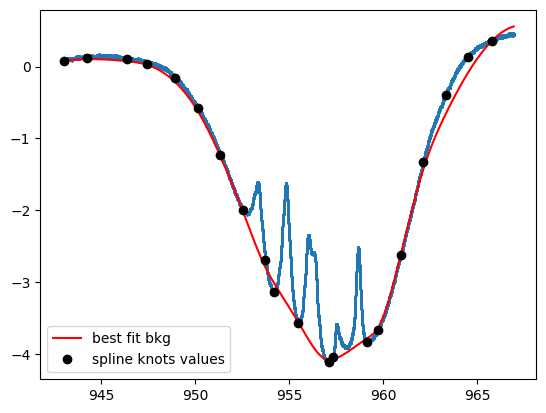

In [22]:
#get the component vals
comps = out.eval_components()

#og data
plt.scatter(x_aveg, y_aveg, s=1)
#best fit
plt.plot(x_aveg, out.best_fit, label='best fit bkg', color= 'red')
#background
# plt.plot(x_aveg, comps['bkg_'], label='background')
#gauss
# plt.plot(x_aveg, comps['gauss_'], label = 'gauss')
#splines
plt.plot(x_aveg[xknots_indices], knot_yvals, 'o', color='black', label='spline knots values')


# plt.plot(x, comps['l1_'], label='peak')
# plt.plot(x, comps['l2_'], label='peak')
# plt.plot(x, comps['l3_'], label='peak')
# plt.plot(x, comps['l4_'], label='peak')

plt.legend()



### eval peaks

In [23]:
ynew = y_aveg - comps['bkg_']
ynew *= 100

NameError: name 'ysubtract_gauss' is not defined

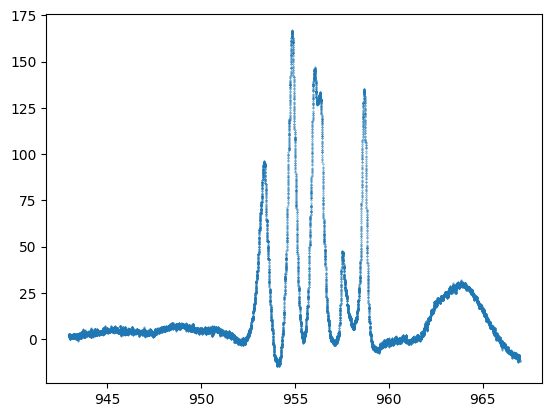

In [24]:
# plt.scatter(x,y,s=0.1)
# plt.plot(x, comps['bkg_'], label='background')
plt.scatter(x_aveg, ynew, s = 0.1, label = 'ynew')
plt.scatter(x_aveg, ysubtract_gauss*100, s = 0.1, label = 'ysubtractgauss')
plt.scatter(x_aveg, y_aveg*100+300, s=0.1, label = 'yaveg', color= 'red')
# plt.xlim(951, 953)
print('literally same shit')
plt.legend()


(950.0, 960.0)

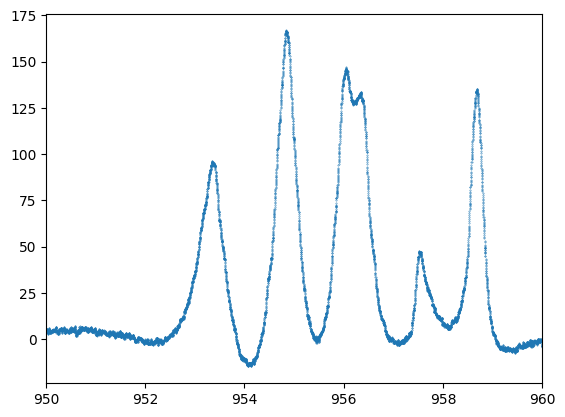

In [84]:
plt.scatter(x_aveg, ynew, s = 0.1, label = 'ynew')
plt.xlim(950, 960)

In [31]:
left = int(np.abs(x_aveg-952).argmin())
x[left]

951.9936

### honestly, Looks like either Gauss or even the complicated Spline fit have more or less same peaks - let's see after eval

In [85]:
centers = [
    953,
    955,
    956,
    956.5,
    957.5,
    959




]

In [86]:
lorentzians = np.zeros(6, dtype=object)
for i in range(6):
    lorentzians[i] = LorentzianModel(prefix=('l'+f'{i}'+'_'))
    # print('l'+f'{i}'+'_')
    # print(lorentzians[i])
    if i == 0:
        print(i)
        params = lorentzians[i].make_params(
            center = centers[i],
            sigma = 0.2,
            amplitude = 80
        )
    else:
        # print(i)
        params.update(lorentzians[i].make_params(
            center = centers[i],
            sigma = 0.2,
            amplitude = 80
        ))

0


In [87]:
# l1 = LorentzianModel(prefix='l1_')

# params = l1.make_params(
#     center = centers[0], 
#     sigma = 0.4,
#     amplitude = 120
# )

# l2 = LorentzianModel(prefix='l2_')
# params = params.update(l2.make_params(
#     center = dict(value = centers[1], max = 952.1, min = 951.8),
#     sigma= dict(value = 0.2, max=0.4),
#     amplitude = 10
# ))

# l3a = LorentzianModel(prefix='l3a_')
# params = params.update(l3a.make_params(
#     center = dict(value=953),
#     sigma = 0.3,
#     amplitude =  100
# ))
# l3b = LorentzianModel(prefix='l3b_')
# params = params.update(l3b.make_params(
#     center = dict(value=953),
#     sigma = 0.3,
#     amplitude =  100
# ))

# l4 = LorentzianModel(prefix='l4_')
# params = params.update(l4.make_params(
#     center = dict(value =954),
#     sigma = 0.5,
#     amplitude = 120
# ))

# l5 = LorentzianModel(prefix='l5_')
# params = params.update(l5.make_params(
#     center = dict(value =955.5),
#     sigma = 0.5,
#     amplitude = 50
# ))

In [88]:
model = lorentzians[0]
for i in range(1,6):
    model += lorentzians[i]

init = model.eval(params, x=x_aveg)
out = model.fit(ynew, params, x=x_aveg)
print(out.fit_report(min_correl=0.3))


[[Model]]
    (((((Model(lorentzian, prefix='l0_') + Model(lorentzian, prefix='l1_')) + Model(lorentzian, prefix='l2_')) + Model(lorentzian, prefix='l3_')) + Model(lorentzian, prefix='l4_')) + Model(lorentzian, prefix='l5_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 329
    # data points      = 19991
    # variables        = 18
    chi-square         = 2376940.44
    reduced chi-square = 119.007683
    Akaike info crit   = 95558.7402
    Bayesian info crit = 95700.9949
    R-squared          = 0.87574747
[[Variables]]
    l0_amplitude:  57.9639536 +/- 0.59040546 (1.02%) (init = 80)
    l0_center:     953.322050 +/- 0.00188025 (0.00%) (init = 953)
    l0_sigma:      0.18755820 +/- 0.00269125 (1.43%) (init = 0.2)
    l0_fwhm:       0.37511640 +/- 0.00538249 (1.43%) == '2.0000000*l0_sigma'
    l0_height:     98.3721338 +/- 0.98625885 (1.00%) == '0.3183099*l0_amplitude/max(1e-15, l0_sigma)'
    l1_amplitude:  84.6283773 +/- 0.55340916 (0.65%) (init = 80)

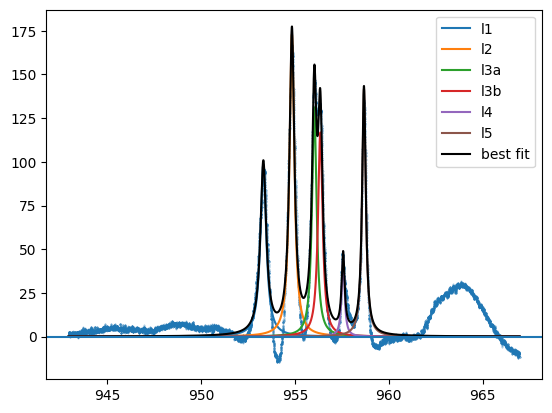

In [89]:
comps = out.eval_components()
plt.plot(x_aveg, comps['l0_'], label='l1')
plt.plot(x_aveg, comps['l1_'], label='l2')
plt.plot(x_aveg, comps['l2_'], label='l3a')
plt.plot(x_aveg, comps['l3_'], label='l3b')
plt.plot(x_aveg, comps['l4_'], label='l4')
plt.plot(x_aveg, comps['l5_'], label='l5')
# plt.plot()
plt.plot(x_aveg, out.best_fit, label='best fit', color= 'black', alpha = 1)
plt.scatter(x_aveg,ynew,s=0.1, alpha = 0.5)
plt.axhline(0)
# plt.xlim(950,956)
plt.legend()

### result centers

In [90]:
result_peaks = np.zeros(6)
i = 0
for name, param in out.params.items():
    if 'center' in name:
        print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')
        result_peaks[i] = param.value
        i+=1 
print(result_peaks)

l0_center   953.32205     0.00188
l1_center   954.84248     0.00098
l2_center   956.03297     0.00170
l3_center   956.35220     0.00197
l4_center   957.56728     0.00301
l5_center   958.67471     0.00103
[953.32204973 954.84248169 956.03296847 956.3522029  957.56727692
 958.67470824]


In [93]:
transitionsf3 = [0, 151.21, 352.45000000000005] + [ 75.605 ,251.83 , 176.225]
transitionsf4 = [0, 201.24, 452.24] + [100.62 ,326.74 ,226.12]
result_peaks -= result_peaks[0]


Text(0.5, 1.0, 'F3 transitions')

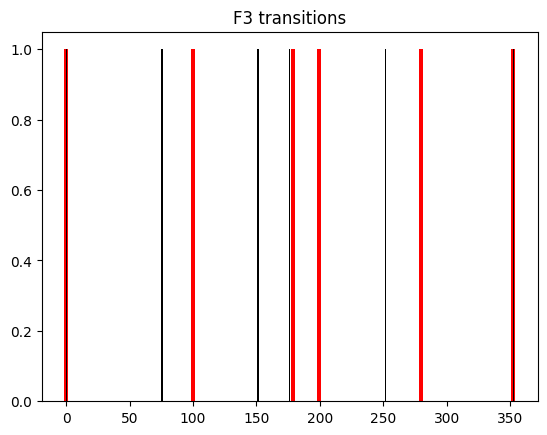

In [96]:
plt.bar(result_peaks*(max(transitionsf3)/result_peaks[-1]), height=np.ones(6), width=3, color = 'red')
plt.bar(transitionsf3, height=np.ones(6), width=1, color = 'black', linestyle ='-')\

plt.title('F3 transitions')


<BarContainer object of 6 artists>

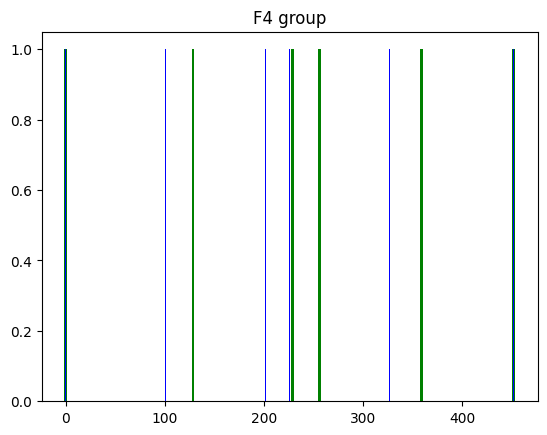

In [97]:
plt.title('F4 group')
plt.bar(result_peaks*(max(transitionsf4)/result_peaks[-1]), height=np.ones(6), width=3, color ='green')
plt.bar(transitionsf4, height=np.ones(6), width=1, color = 'blue')